In [141]:
# ==========================
# Titanic Survivors Prediction
# ==========================

# --------------------------
# 1️⃣ Import Libraries
# --------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [142]:
# --------------------------
# 2️⃣ Load Data
# --------------------------
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

# Check data
print(train_df.head())
print(train_df.info())
print(train_df.isna().sum())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

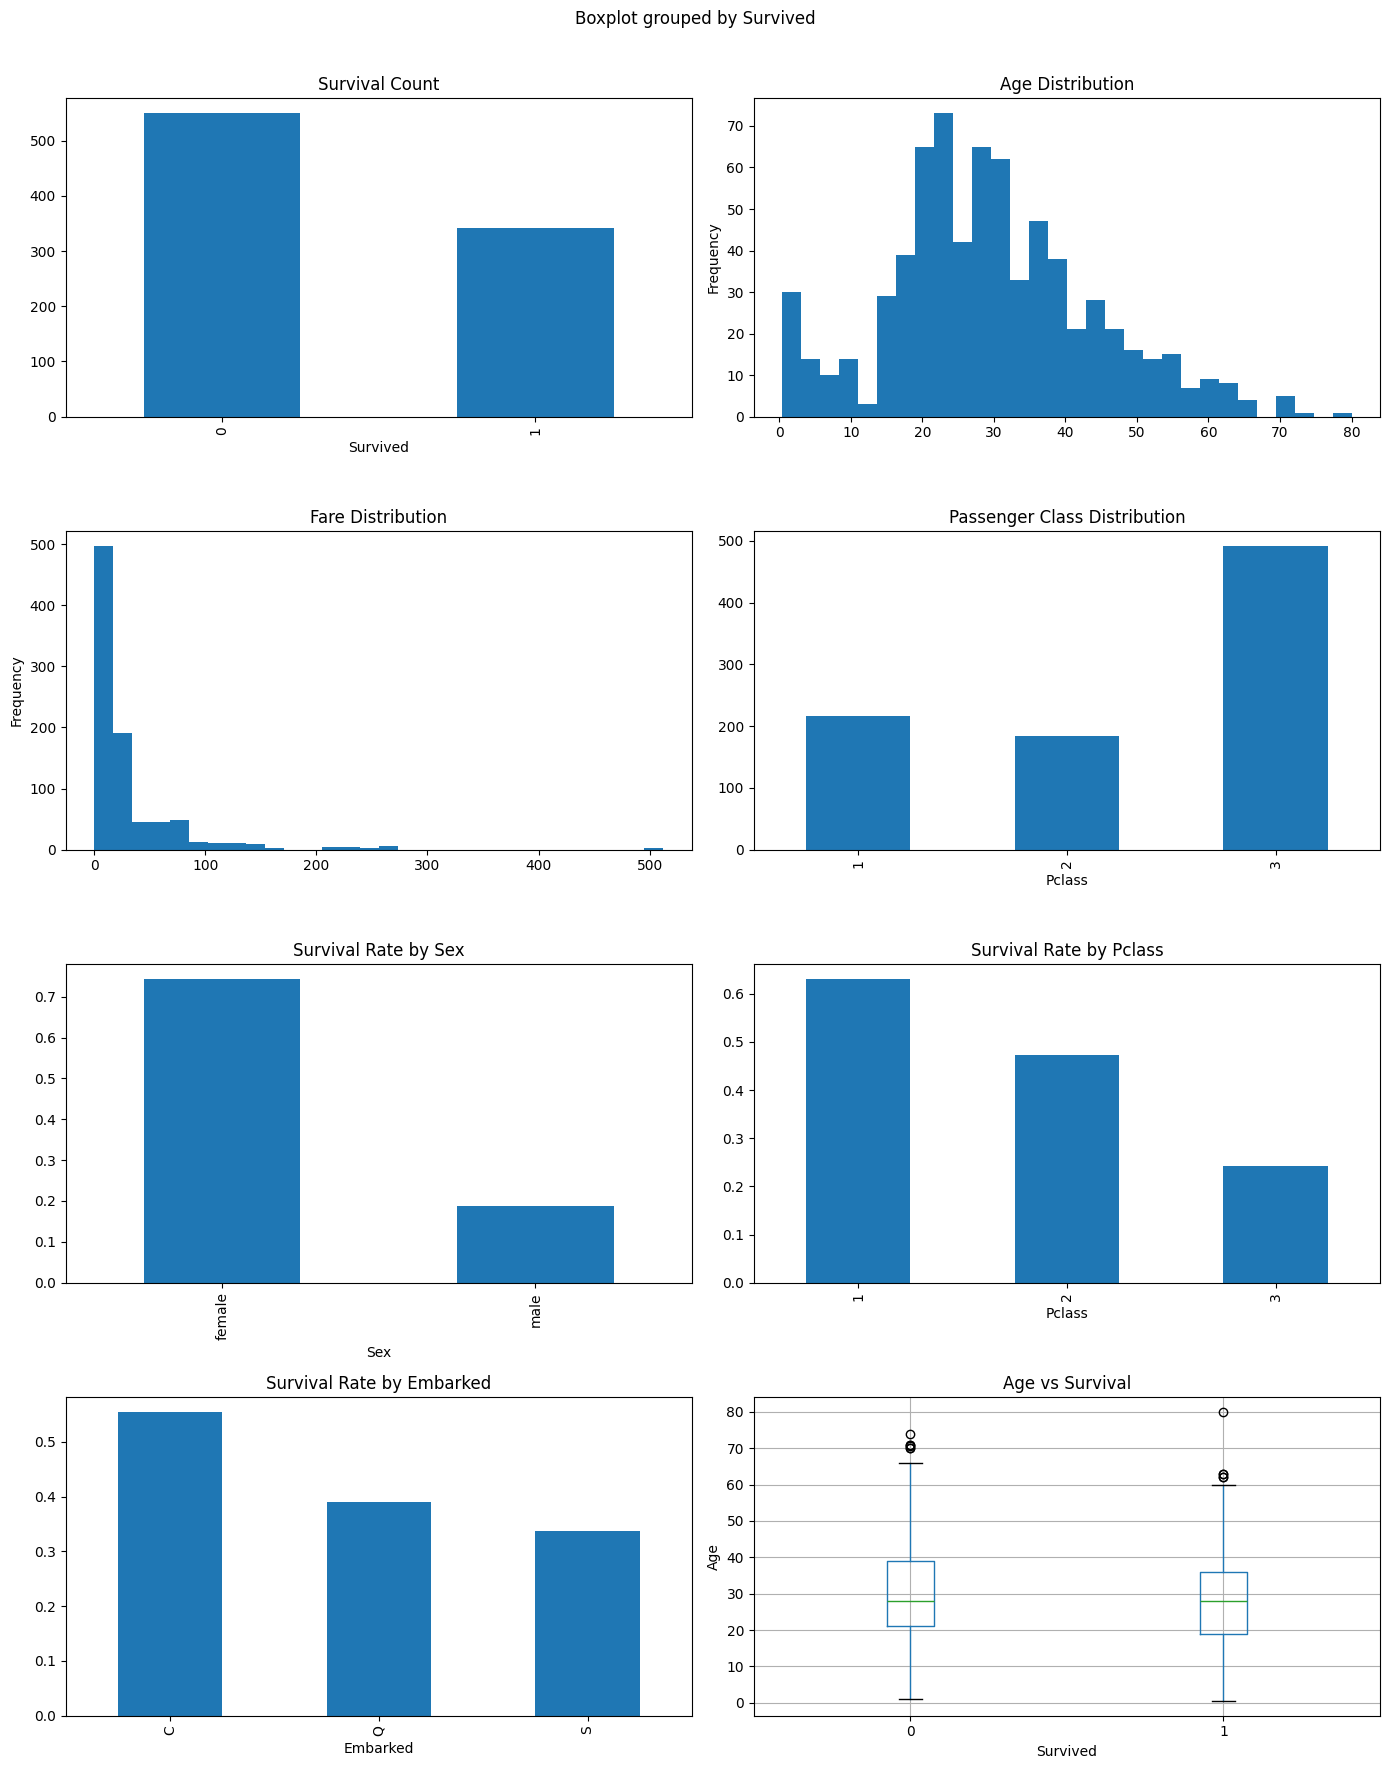

/var/folders/m7/0_0fncmd2wjdnnwhtv16d0bw0000gn/T/ipykernel_73034/3707845054.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby("AgeGroup")["Survived"].mean().plot(kind="bar")


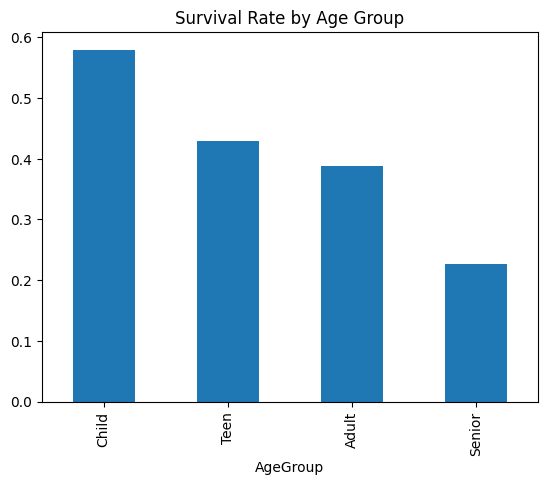

In [143]:
# --------------------------
# 3️⃣ Exploratory Data Analysis (EDA)
# --------------------------
def eda_plots(df):
    fig, axes = plt.subplots(4, 2, figsize=(14, 18))
    fig.suptitle("Titanic Exploratory Data Analysis", fontsize=16)

    # 1. Class imbalance
    df["Survived"].value_counts().plot(kind="bar", ax=axes[0, 0], title="Survival Count")

    # 2. Age distribution
    df["Age"].plot(kind="hist", bins=30, ax=axes[0, 1], title="Age Distribution")

    # 3. Fare distribution
    df["Fare"].plot(kind="hist", bins=30, ax=axes[1, 0], title="Fare Distribution")

    # 4. Pclass count
    df["Pclass"].value_counts().sort_index().plot(
        kind="bar", ax=axes[1, 1], title="Passenger Class Distribution"
    )

    # 5. Survival rate by Sex
    df.groupby("Sex")["Survived"].mean().plot(
        kind="bar", ax=axes[2, 0], title="Survival Rate by Sex"
    )

    # 6. Survival rate by Pclass
    df.groupby("Pclass")["Survived"].mean().plot(
        kind="bar", ax=axes[2, 1], title="Survival Rate by Pclass"
    )

    # 7. Survival rate by Embarked
    df.groupby("Embarked")["Survived"].mean().plot(
        kind="bar", ax=axes[3, 0], title="Survival Rate by Embarked"
    )

    # 8. Age vs Survived
    df.boxplot(column="Age", by="Survived", ax=axes[3, 1])
    axes[3, 1].set_title("Age vs Survival")
    axes[3, 1].set_xlabel("Survived")
    axes[3, 1].set_ylabel("Age")

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Run EDA
eda_plots(train_df)

# Survival rate by age group
train_df["AgeGroup"] = pd.cut(
    train_df["Age"], bins=[0, 12, 18, 60, 100],
    labels=["Child", "Teen", "Adult", "Senior"]
)
train_df.groupby("AgeGroup")["Survived"].mean().plot(kind="bar")
plt.title("Survival Rate by Age Group")
plt.show()


In [ ]:
# --------------------------
# 4️⃣ Data Preprocessing & Feature Engineering
# --------------------------
def preprocess_titanic(train_df: pd.DataFrame, test_df: pd.DataFrame):
    """
    Preprocess Titanic train and test datasets:
    - Handle missing values
    - Encode categorical variables
    - Feature engineering: Title, FamilySize, AgeGroup
    """
    y_train = train_df["Survived"]
    X_train = train_df.drop(columns=["Survived"])

    # TRAIN statistics
    age_median = X_train["Age"].median()
    fare_median = X_train["Fare"].median()
    embarked_mode = X_train["Embarked"].mode()[0]

    def clean(df):
        df = df.copy()
        # Fill missing
        df["Age"].fillna(age_median, inplace=True)
        df["Fare"].fillna(fare_median, inplace=True)
        df["Embarked"].fillna(embarked_mode, inplace=True)
        df.drop(columns=["Cabin"], inplace=True)
        # Encode categorical
        df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
        df = pd.get_dummies(df, columns=["Embarked"], prefix="Embarked")
        # Feature engineering
        df["Title"] = df["Name"].str.extract(r", (\w+)\.")[0]
        df["Title"] = df["Title"].replace(
            ["Lady","Countess","Capt","Col","Don","Dr","Major","Rev","Sir","Jonkheer","Dona"], "Rare"
        )
        df["Title"] = df["Title"].map({"Mr":0, "Miss":1, "Mrs":2, "Master":3, "Rare":4})
        df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
        df["AgeGroup"] = pd.cut(
            df["Age"], bins=[0, 12, 18, 60, 100],
            labels=[0, 1, 2, 3]  # 0:Child, 1:Teen, 2:Adult, 3:Senior
        ).astype(int)
        # Drop Name and Ticket (non-numeric, not needed)
        df.drop(columns=["Name", "Ticket"], inplace=True)
        return df

    X_train = clean(X_train)
    X_test = clean(test_df)

    return X_train, y_train, X_test

# Apply preprocessing
X_train, y_train, X_test = preprocess_titanic(train_df, test_df)

# Check
print(X_train.head())
print(X_train.isna().sum())
print(X_test.isna().sum())

In [ ]:
# --------------------------
# 5️⃣ Train/Test Split
# --------------------------
X_train_split, X_valid, y_train_split, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

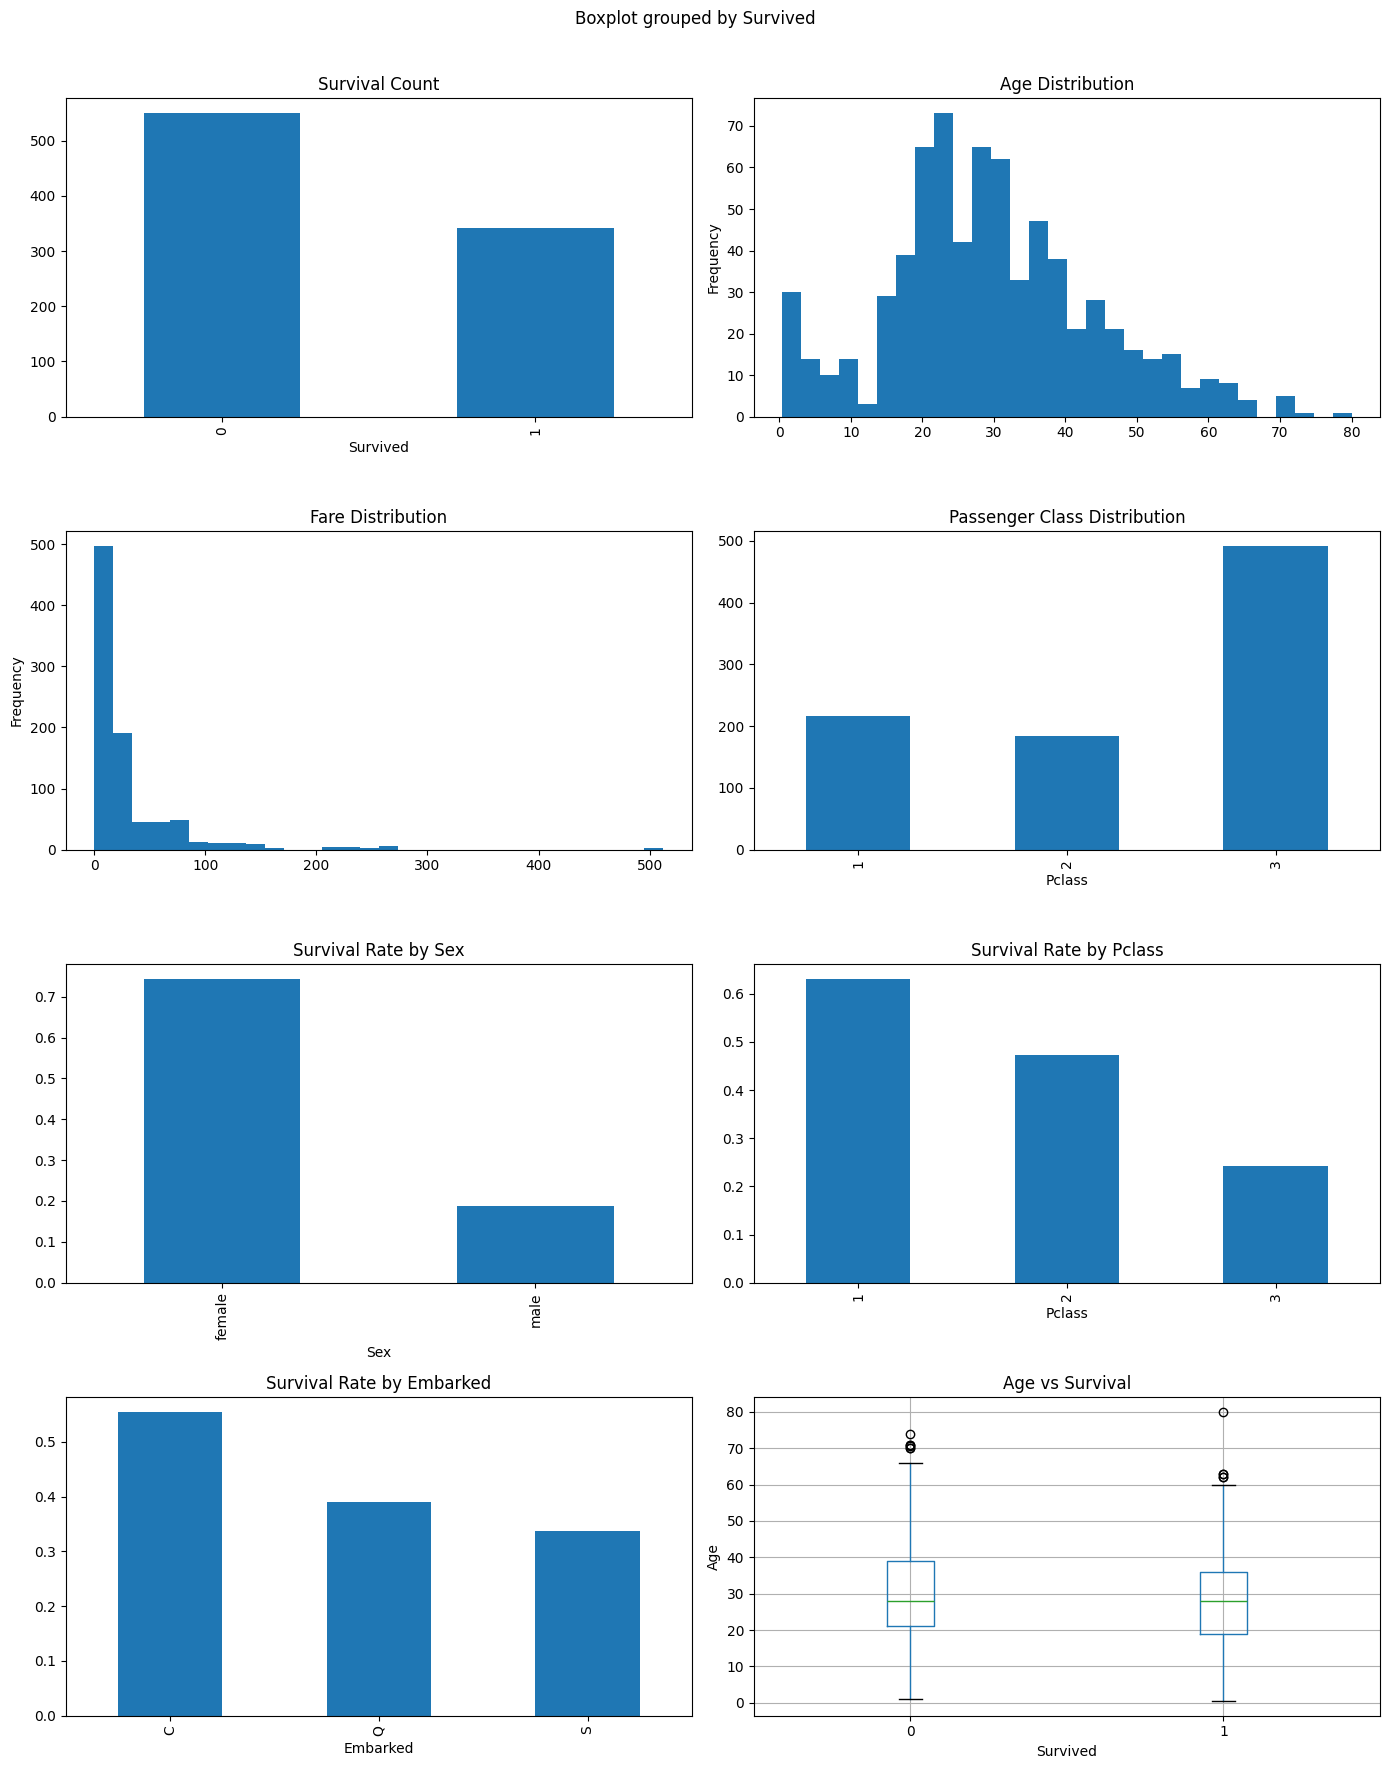

/var/folders/m7/0_0fncmd2wjdnnwhtv16d0bw0000gn/T/ipykernel_73034/2274025969.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby("AgeGroup")["Survived"].mean().plot(kind="bar")


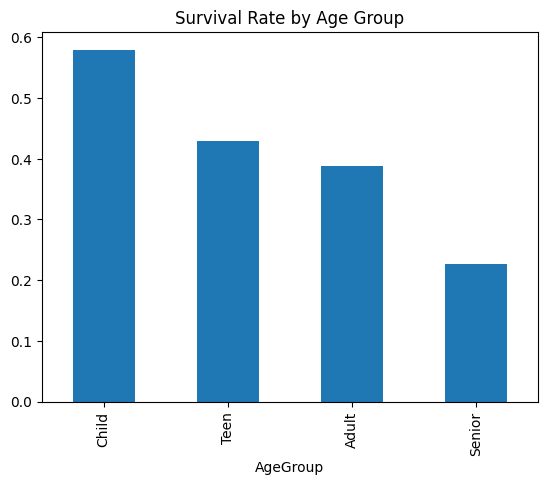

   PassengerId  Pclass  Sex   Age  SibSp  Parch     Fare  AgeGroup  \
0            1       3    0  22.0      1      0   7.2500         2   
1            2       1    1  38.0      1      0  71.2833         2   
2            3       3    1  26.0      0      0   7.9250         2   
3            4       1    1  35.0      1      0  53.1000         2   
4            5       3    0  35.0      0      0   8.0500         2   

   Embarked_C  Embarked_Q  Embarked_S  Title  FamilySize  
0       False       False        True    0.0           2  
1        True       False       False    2.0           2  
2       False       False        True    1.0           1  
3       False       False        True    2.0           2  
4       False       False        True    0.0           1  
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
AgeGroup       0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
Title          5
FamilySize     0
dtyp

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:




# --------------------------
# 6️⃣ Model Training & Evaluation
# --------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100)
}

for name, model in models.items():
    model.fit(X_train_split, y_train_split)
    y_pred = model.predict(X_valid)
    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_valid, y_pred))
    print(classification_report(y_valid, y_pred))
    cm = confusion_matrix(y_valid, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"{name} Confusion Matrix")
    plt.show()



In [144]:
# --------------------------
# 7️⃣ Optional: Hyperparameter Tuning (GridSearchCV)
# --------------------------
# Example for Random Forest
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5]
}
grid_rf = GridSearchCV(RandomForestClassifier(), rf_params, cv=5)
grid_rf.fit(X_train_split, y_train_split)
print("Best RF Params:", grid_rf.best_params_)
print("Best CV Score:", grid_rf.best_score_)

Best RF Params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
Best CV Score: 0.8300108342361863
